# Compute the Average Attention Weights for Each Layer

In [ ]:
import os
import pandas as pd

# Set working directory and define paths for input and output data
work_dir = os.getcwd()  # Set the current directory as the working directory
input_data_dir = os.path.join(work_dir, '../Data')  # Define input data location as ../Data
output_dir = os.path.join(work_dir, '../Data')  # Define output data location as ../Data

# Change to input data directory
os.chdir(input_data_dir)

# Load the attention weights data from the TSV file
SD10data = pd.read_csv("attention_weights.tsv", sep="\t")

# Calculate the average attention for each layer by selecting all heads in each layer and rounding to four decimal places
SD10data['attn_layer_1_avg'] = SD10data.filter(regex='^attn_weights_1_head').mean(axis=1).round(4)
SD10data['attn_layer_2_avg'] = SD10data.filter(regex='^attn_weights_2_head').mean(axis=1).round(4)
SD10data['attn_layer_3_avg'] = SD10data.filter(regex='^attn_weights_3_head').mean(axis=1).round(4)

# Select only the necessary columns for the output: cpm_id, Source, Target, and the average attention values
attention_data = SD10data[['cpm_id', 'Source', 'Target', 'attn_layer_1_avg', 'attn_layer_2_avg', 'attn_layer_3_avg']]

# Define the output file path and save the resulting DataFrame as a new TSV file
output_file = os.path.join(output_dir, "attention_averages.tsv")
attention_data.to_csv(output_file, sep="\t", index=False)

# Print a confirmation message with the path of the output file
print(f"Average attention weights saved to {output_file}")


# Calculate Mutual Attention Between Nodes

In [ ]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# Set working directory and define input/output paths
work_dir = os.getcwd()  # Use the current directory as the working directory
input_data_dir = os.path.join(work_dir, '../Data')  # Define ../Data as the location for input data
output_dir = os.path.join(work_dir, '../Data')  # Define ../Data as the location for output data

# Define file paths
file_path = os.path.join(input_data_dir, "attention_averages.tsv")

# Load attention data from file
attention_data = pd.read_csv(file_path, sep='\t')

# Retrieve all unique cpm_id values
cpm_ids = attention_data['cpm_id'].unique()

# Define output file path
output_path = os.path.join(output_dir, "calculated_attention_weights.tsv")

# If the output file already exists, delete it to avoid interference from old data
if os.path.exists(output_path):
    os.remove(output_path)

# Initialize the output file by writing the header
with open(output_path, 'w', encoding='utf-8') as f_out:
    f_out.write('cpm_id\tSource\tTarget\tattention\n')

# Set batch size for processing to handle data in chunks
batch_size = 100
batch_results = []  # Initialize list to store batch results temporarily

# Process each unique cpm_id with progress tracking using tqdm
for idx, cpm_id in enumerate(tqdm(cpm_ids, desc="Processing cpm_id")):
    # Filter data for the current cpm_id
    cpm_data = attention_data[attention_data['cpm_id'] == cpm_id]

    # Retrieve and sort all nodes involved in the current cpm_id
    nodes = sorted(pd.unique(cpm_data[['Source', 'Target']].values.ravel()))

    # Use defaultdict to accumulate attention weights across edges
    attention_dict = defaultdict(float)

    # Calculate multi-layer attention contribution for each target node
    for target in nodes:
        # Third layer: nodes directly connected to the target node
        third_layer = cpm_data[cpm_data['Target'] == target]

        for _, third_row in third_layer.iterrows():
            source_3 = third_row['Source']
            weight_3 = third_row['attn_layer_3_avg']

            # Second layer: nodes connected to nodes in the third layer
            second_layer = cpm_data[cpm_data['Target'] == source_3]

            for _, second_row in second_layer.iterrows():
                source_2 = second_row['Source']
                weight_2 = second_row['attn_layer_2_avg']

                # First layer: nodes connected to nodes in the second layer
                first_layer = cpm_data[cpm_data['Target'] == source_2]

                for _, first_row in first_layer.iterrows():
                    source_1 = first_row['Source']
                    weight_1 = first_row['attn_layer_1_avg']

                    # Calculate the total weight as the product of weights across three layers
                    total_weight = weight_1 * weight_2 * weight_3

                    # Accumulate the weight in the dictionary with the source-target key
                    attention_dict[(source_1, target)] += total_weight

    # Convert the accumulated attention results to a DataFrame for the current cpm_id
    results = [[cpm_id, src, tgt, weight] for (src, tgt), weight in attention_dict.items()]
    attention_df = pd.DataFrame(results, columns=["cpm_id", "Source", "Target", "attention"])

    # Round attention values to six significant figures for clarity and consistency
    attention_df['attention'] = attention_df['attention'].apply(lambda x: round(x, 6))

    # Add the results to the batch results list
    batch_results.append(attention_df)

    # Write results to the file when reaching batch size or the last cpm_id
    if (idx + 1) % batch_size == 0 or (idx + 1) == len(cpm_ids):
        # Combine batch results into a single DataFrame
        combined_df = pd.concat(batch_results, ignore_index=True)
        
        # Append batch results to the output file
        combined_df.to_csv(output_path, sep='\t', index=False, header=False, mode='a', encoding='utf-8')
        
        # Clear batch results to free memory for the next batch
        batch_results = []

# Print completion message
print(f"All attention weights for cpm_id have been saved to {output_path}")


# Figure

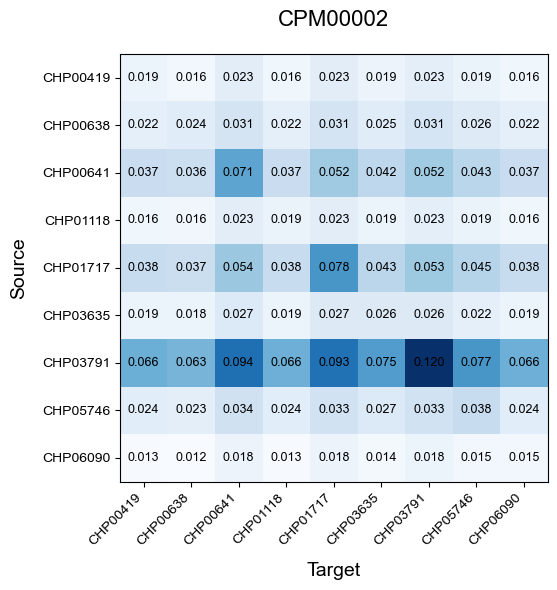

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Set working directory and define input/output paths
work_dir = os.getcwd()
input_data_dir = os.path.join(work_dir, '../Data')
output_dir = os.path.join(work_dir, '../Figure')

# Load data
D6_data = pd.read_csv(os.path.join(input_data_dir, "Chinese_herbal_pieces.tsv"), sep="\t")
attention_weights = pd.read_csv(os.path.join(input_data_dir, "calculated_attention_weights.tsv"), sep="\t")

# Filter rows where both Source and Target start with "CHP", and where Source and Target are not the same
attention_filtered = attention_weights[
    attention_weights['Source'].str.startswith("CHP") &
    attention_weights['Target'].str.startswith("CHP")
]

# Extract specific cpm_id, e.g., "CPM00002"
cpm_id = "CPM00002"
cpm_id_data = attention_filtered[attention_filtered['cpm_id'] == cpm_id]

# Convert data into a matrix format suitable for heatmap plotting
heatmap_data = cpm_id_data.pivot(index='Source', columns='Target', values='attention').fillna(0)

# Set pinyin_term as the selected cpm_id (can be used for title)
pinyin_term = cpm_id

# Set font to Arial for English text display
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False  # Prevent negative signs from displaying as boxes

# Set figure dimensions for content display
pdf_width, pdf_height = 8, 6  # Specify PDF output size

# Use matplotlib to plot the heatmap
fig, ax = plt.subplots(figsize=(pdf_width, pdf_height))
cax = ax.matshow(heatmap_data, cmap="Blues")

# Display each cell's value with three significant digits
for (i, j), val in np.ndenumerate(heatmap_data.values):
    ax.text(j, i, f"{val:.3f}", ha='center', va='center', color="black", fontsize=9)

# Set axis labels and title
ax.set_xticks(np.arange(len(heatmap_data.columns)))
ax.set_yticks(np.arange(len(heatmap_data.index)))
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(heatmap_data.index, fontsize=10)
ax.xaxis.set_ticks_position('bottom')
plt.xlabel("Target", fontsize=14, labelpad=10)
plt.ylabel("Source", fontsize=14, labelpad=10)
plt.title(f'{pinyin_term}', fontsize=16, pad=20)

# Remove color bar
fig.colorbar(cax, ax=ax).remove()

# Adjust layout to ensure compact display with no extra white space
plt.tight_layout()

# Save as PDF and ensure page size matches specified dimensions
plt.savefig(
    os.path.join(output_dir, f"{pinyin_term}_Attention_Heatmap.pdf"),
    format='pdf',
    bbox_inches='tight',  # Remove extra white space
    pad_inches=0.1,  # Control padding around content
    dpi=300  # Adjust resolution for higher quality output
)

# Display the plot
plt.show()
